In [2]:
import os #
import numpy as np #
import pandas as pd #
from pathlib import Path #
import multiprocessing as mp #
from itertools import permutations #
from matplotlib import pyplot as plt #

#-----CLASSIFIER------
from sklearn.svm import SVC #
from sklearn import metrics #
from sklearn import preprocessing #
from sklearn.utils import resample #
from sklearn.preprocessing import normalize #
from sklearn.metrics import balanced_accuracy_score #
from sklearn.ensemble import RandomForestClassifier #
from sklearn.model_selection import RandomizedSearchCV #

### Dividing samles into groups by the sequencing batches

In [3]:
#-----read FMBA metadata------
FMBA_metadata=pd.read_csv("../fmba/fmba_metadata_edited.tsv", sep=",",header=0, dtype = str)
print("FMBA_metadata \n", FMBA_metadata.COVID_status.value_counts())

#-----read Adaptive metadata------
AB_metadata=pd.read_csv("../adaptive/adaptive-metadata-edited.tsv",sep="\t")
AB_metadata["sample_short_name"]=AB_metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names
print("\nAdaptive_metadata \n", AB_metadata["COVID-19-status"].value_counts())

FMBA_metadata 
 COVID       1061
healthy      433
precovid     118
unknown       27
Name: COVID_status, dtype: int64

Adaptive_metadata 
 acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64


In [4]:
#----METADATA-----
#----select FMBA cohorts-----
fmba_COVID=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='COVID', "name"])
print("fmba_COVID:", len(fmba_COVID))
fmba_healthy=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='healthy', "name"])
print("fmba_healthy:", len(fmba_healthy))
fmba_precovid=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='precovid', "name"])
print("fmba_precovid:", len(fmba_precovid))

#----select Adaptive cohorts-----
adaptive_acute=set(AB_metadata.loc[AB_metadata["COVID-19-status"]=="acute","sample_short_name"])
print("\nAdaptive_acute:",  len(adaptive_acute))
HIP=set(pd.read_csv("/projects/fmba_covid/COV_V_usage_adjustment_count_equation_v3/HIP_functional_adjusted/metadata.txt", sep="\t", header=None)[0])
HIP={xT.split(".")[0] for xT in HIP}
print("HIP:",  len(HIP))
KECK=set(pd.read_csv("/projects/fmba_covid/COV_V_usage_adjustment_count_equation_v3/KECK_functional_adjusted/metadata.txt", sep="\t", header=None)[0])
KECK={xT.split("_")[0] for xT in KECK}
print("KECK:",  len(KECK))

fmba_COVID: 1061
fmba_healthy: 433
fmba_precovid: 118

Adaptive_acute: 1140
HIP: 665
KECK: 120


In [16]:
FMBA_metadata['COVID_status'].value_counts()

COVID       1061
healthy      433
precovid     118
unknown       27
Name: COVID_status, dtype: int64

In [5]:
#-----sequencing runs-----
FMBA_metadata["sequencingDate"].value_counts()

2020 10 19    566
2020 12 18    377
2020 09 05    192
2020 09 28    191
2020 09 27    189
2021 01 07    118
2021 02 13      6
Name: sequencingDate, dtype: int64

In [6]:
#-----datasets-----
AB_metadata=AB_metadata.loc[AB_metadata["COVID-19-status"]=="acute"]
AB_metadata["Dataset"].value_counts()

COVID-19-DLS                     433
COVID-19-NIH/NIAID               357
COVID-19-HUniv12Oct              177
COVID-19-ISB                      69
COVID-19-IRST/AUSL                64
COVID-19-Adaptive                 37
COVID-19-Adaptive-MIRAMatched      3
Name: Dataset, dtype: int64

In [7]:
fmba_set1_={"2020 09 27", "2020 12 18", "2020 10 19"}
fmba_set2_={"2020 09 05", "2020 09 28", "2021 01 07"} # 2021 01 07==precovid
fmba_set1_=set(FMBA_metadata.loc[FMBA_metadata["sequencingDate"].isin(fmba_set1_), "name"])
fmba_set2_=set(FMBA_metadata.loc[FMBA_metadata["sequencingDate"].isin(fmba_set2_), "name"])

adaptive_set1_={"COVID-19-NIH/NIAID", "COVID-19-HUniv12Oct", "COVID-19-Adaptive", "KECK"}
adaptive_set2_={"COVID-19-DLS", "COVID-19-ISB", "COVID-19-IRST/AUSL", "HIP"}
adaptive_set1_=set(AB_metadata.loc[AB_metadata["Dataset"].isin(adaptive_set1_), "sample_short_name"]) | KECK
adaptive_set2_=set(AB_metadata.loc[AB_metadata["Dataset"].isin(adaptive_set2_), "sample_short_name"]) | HIP

In [8]:
#-----read Adaptive and HIP data-----
AB_data=pd.read_csv("../feature_search/wilcox_test/FREQ_TABLES/Adaptive/Adaptive_top_5000AA/Adaptive_associated_clones_thomas_.tsv",
                    sep="\t", index_col=0)
AB_data.index=[xT.split("_")[0] for xT in AB_data.index]

HIP_data=pd.read_csv("../feature_search/wilcox_test/FREQ_TABLES/HIP/HIP_top_5000AA/HIP_associated_clones_thomas_.tsv",
                    sep="\t", index_col=0)
HIP_data.index=[xT.split(".")[0] for xT in HIP_data.index]

KECK_data=pd.read_csv("../feature_search/wilcox_test/FREQ_TABLES/KECK/KECK_top_5000AA/KECK_associated_clones_thomas_.tsv",
                    sep="\t", index_col=0)
KECK_data.index=[xT.split("_")[0] for xT in KECK_data.index]

#----read FMBA data------
FMBA_data=pd.read_csv("../feature_search/wilcox_test/FREQ_TABLES/FMBA/FMBA_top_5000AA/FMBA_associated_clones_thomas_.tsv",
                    sep="\t", index_col=0)
FMBA_data.index=list(map(lambda x: x[0 : (x.rfind("S")-1)], FMBA_data.index))

In [9]:
#-----STATUS-----
print("number of samples in data:\n")

#-----FMBA data-----
FMBA_data_=FMBA_data.loc[FMBA_data.index.isin(fmba_COVID) | FMBA_data.index.isin(fmba_healthy) | FMBA_data.index.isin(fmba_precovid)]
FMBA_data_.loc[FMBA_data_.index.isin(fmba_COVID) , "status"]="COVID"
FMBA_data_.loc[FMBA_data_.index.isin(fmba_healthy) , "status"]="healthy"
FMBA_data_.loc[FMBA_data_.index.isin(fmba_precovid) , "status"]="healthy"
fmba_set1=FMBA_data_.loc[FMBA_data_.index.isin(fmba_set1_)]
print("fmba_set1", len(fmba_set1))
print("fmba_set1_COVID", len(fmba_set1.loc[fmba_set1.index.isin(fmba_COVID) | fmba_set1.index.isin(fmba_precovid)]))
print("fmba_set1_HEALTHY", len(fmba_set1.loc[fmba_set1.index.isin(fmba_healthy)]))
fmba_set2=FMBA_data_.loc[FMBA_data_.index.isin(fmba_set2_)]
print("fmba_set2", len(fmba_set2))
print("fmba_set2_COVID", len(fmba_set2.loc[fmba_set2.index.isin(fmba_COVID)]))
print("fmba_set2_HEALTHY", len(fmba_set2.loc[fmba_set2.index.isin(fmba_precovid)]))

#-----Adaptive data-----
AB_data_=AB_data.loc[AB_data.index.isin(adaptive_acute)]
AB_data_["status"]="COVID"
HIP_data["status"]="healthy"
KECK_data["status"]="healthy"
AB_data_=pd.concat([AB_data_, HIP_data, KECK_data])
adaptive_set1=AB_data_.loc[AB_data_.index.isin(adaptive_set1_)]
print("adaptive_set1", len(adaptive_set1))

print("adaptive_set1_COVID", len(adaptive_set1.loc[adaptive_set1.index.isin(adaptive_set1_-KECK)]))
print("adaptive_set1_HEALTHY", len(adaptive_set1.loc[adaptive_set1.index.isin(KECK)]))
adaptive_set2=AB_data_.loc[AB_data_.index.isin(adaptive_set2_)]
print("adaptive_set2", len(adaptive_set2))
print("adaptive_set2_COVID", len(adaptive_set2.loc[adaptive_set2.index.isin(adaptive_set2_-HIP)]))
print("adaptive_set2_HEALTHY", len(adaptive_set2.loc[adaptive_set2.index.isin(HIP)]))

number of samples in data:

fmba_set1 518
fmba_set1_COVID 224
fmba_set1_HEALTHY 294
fmba_set2 272
fmba_set2_COVID 169
fmba_set2_HEALTHY 103


/home/daria/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/daria/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/daria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

adaptive_set1 562
adaptive_set1_COVID 442
adaptive_set1_HEALTHY 120
adaptive_set2 1222
adaptive_set2_COVID 558
adaptive_set2_HEALTHY 664


In [138]:
#-----STATUS-----
#-----NORMALIZATION!!!-----
print("number of samples in data:\n")

#-----FMBA data-----
FMBA_data_=FMBA_data.loc[FMBA_data.index.isin(fmba_COVID) | FMBA_data.index.isin(fmba_healthy) | FMBA_data.index.isin(fmba_precovid)]
FMBA_data_norm=(normalize(FMBA_data_, norm="l1"))
FMBA_data_norm=pd.DataFrame(data=FMBA_data_norm, index=FMBA_data_.index, columns=FMBA_data_.columns)
FMBA_data_norm.loc[FMBA_data_norm.index.isin(fmba_COVID) , "status"]="COVID"
FMBA_data_norm.loc[FMBA_data_norm.index.isin(fmba_healthy) , "status"]="healthy"
FMBA_data_norm.loc[FMBA_data_norm.index.isin(fmba_precovid) , "status"]="healthy"
fmba_set1=FMBA_data_norm.loc[FMBA_data_norm.index.isin(fmba_set1_)]
print("fmba_set1", len(fmba_set1))
print("fmba_set1_COVID", len(fmba_set1.loc[fmba_set1.index.isin(fmba_COVID) | fmba_set1.index.isin(fmba_precovid)]))
print("fmba_set1_HEALTHY", len(fmba_set1.loc[fmba_set1.index.isin(fmba_healthy)]))
fmba_set2=FMBA_data_norm.loc[FMBA_data_norm.index.isin(fmba_set2_)]
print("fmba_set2", len(fmba_set2))
print("fmba_set2_COVID", len(fmba_set2.loc[fmba_set2.index.isin(fmba_COVID)]))
print("fmba_set2_HEALTHY", len(fmba_set2.loc[fmba_set2.index.isin(fmba_precovid)]))

#-----Adaptive data-----
AB_data_=AB_data.loc[AB_data.index.isin(adaptive_acute)]
AB_data_norm=(normalize(AB_data_, norm='l1'))
AB_data_norm=pd.DataFrame(data=AB_data_norm, index=AB_data_.index, columns=AB_data_.columns)
AB_data_norm["status"]="COVID"
HIP_data_norm=(normalize(HIP_data, norm='l1'))
HIP_data_norm=pd.DataFrame(data=HIP_data_norm, index=HIP_data.index, columns=HIP_data.columns)
HIP_data_norm["status"]="healthy"
KECK_data_norm=(normalize(KECK_data, norm='l1'))
KECK_data_norm=pd.DataFrame(data=KECK_data_norm, index=KECK_data.index, columns=KECK_data.columns)
KECK_data_norm["status"]="healthy"
AB_data_=pd.concat([AB_data_norm, HIP_data_norm, KECK_data_norm])
adaptive_set1=AB_data_.loc[AB_data_.index.isin(adaptive_set1_)]
print("adaptive_set1", len(adaptive_set1))
print("adaptive_set1_COVID", len(adaptive_set1.loc[adaptive_set1.index.isin(adaptive_set1_-KECK)]))
print("adaptive_set1_HEALTHY", len(adaptive_set1.loc[adaptive_set1.index.isin(KECK)]))
adaptive_set2=AB_data_.loc[AB_data_.index.isin(adaptive_set2_)]
print("adaptive_set2", len(adaptive_set2))
print("adaptive_set2_COVID", len(adaptive_set2.loc[adaptive_set2.index.isin(adaptive_set2_-HIP)]))
print("adaptive_set2_HEALTHY", len(adaptive_set2.loc[adaptive_set2.index.isin(HIP)]))

number of samples in data:

fmba_set1 518
fmba_set1_COVID 224
fmba_set1_HEALTHY 294
fmba_set2 272
fmba_set2_COVID 169
fmba_set2_HEALTHY 103
adaptive_set1 562
adaptive_set1_COVID 442
adaptive_set1_HEALTHY 120
adaptive_set2 1222
adaptive_set2_COVID 558
adaptive_set2_HEALTHY 664


### Get combinations of training and test sets

In [14]:
#-----combinations of training and test sets-----
model_permutation_=list(permutations(("fmba_set1","fmba_set2", "adaptive_set1","adaptive_set2"), 2))
model_permutation=[]
for i in range(len(model_permutation_)):
    x, y =iter(model_permutation_[i])
    model_permutation.append(f'{x}/{y}')

print("training and test sets:\n")
model_permutation

training and test sets:



['fmba_set1/fmba_set2',
 'fmba_set1/adaptive_set1',
 'fmba_set1/adaptive_set2',
 'fmba_set2/fmba_set1',
 'fmba_set2/adaptive_set1',
 'fmba_set2/adaptive_set2',
 'adaptive_set1/fmba_set1',
 'adaptive_set1/fmba_set2',
 'adaptive_set1/adaptive_set2',
 'adaptive_set2/fmba_set1',
 'adaptive_set2/fmba_set2',
 'adaptive_set2/adaptive_set1']

### Define SVM classifier function

In [390]:
#-----SVM------
output_folder="model_comparison/"
output_file=output_folder+"/"+"svm_model_comparison_new.tsv"

parameters = {"C": [0.01, 0.5, 1], "kernel": ["rbf"], "degree": [1, 2], "gamma": ["scale"]} 
column_names=[*["normalization", "features", "mismatch", "weight"], *model_permutation]
datasets=list(permutations((fmba_set1, fmba_set2, adaptive_set1, adaptive_set2), 2))

def run_classifier_svm(normalization, features, mismatch, weight,
                   datasets, parameters=parameters, column_names=column_names,
                   output_folder=output_folder, output_file=output_file):   
    scores=[]
    best_parameters=[]
    for dataset in datasets:
        train_set, test_set=iter(dataset)
#------split into features matrix X and vector with ansvers y-----
        X_to_fit=train_set[train_set.columns[~train_set.columns.isin(["status"])]]
        y_to_fit=train_set["status"]
        X_test=test_set[test_set.columns[~test_set.columns.isin(["status"])]]
        y_test=test_set["status"]

        '''
        #-----Oversample minority class------        
        # concatenate our training data back together
        X = pd.concat([X_to_fit, y_to_fit], axis=1)
        # separate minority and majority classes
        lb = preprocessing.LabelBinarizer() #COVID-0, healthy-1
        y_bin=lb.fit_transform(y_to_fit)
        inx_min=np.argmin(np.bincount(y_bin.ravel()))
        inx_max=int(not inx_min)
        class_bin={0: "COVID", 1: "healthy"}
        minor=X[X.status==class_bin[inx_min]]
        major=X[X.status==class_bin[inx_max]]
        # upsample minority
        minor_upsampled = resample(minor,
                                  replace=True, # sample with replacement
                                  n_samples=len(major), # match number in majority class
                                  random_state=27) # reproducible results
        # combine majority and upsampled minority
        upsampled = pd.concat([major, minor_upsampled])
        y_to_fit=upsampled.status
        X_to_fit=upsampled.drop('status', axis=1)

        '''
        
#-----find hyperparameters----
        clf=RandomizedSearchCV(SVC(class_weight="balanced"), parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        clf.fit(X_to_fit, y_to_fit)
        #-----best estimator-----
        SVM=clf.best_estimator_
        best_parameter=clf.best_params_
        best_parameters.append(best_parameter)
        y_pred=SVM.predict(X_test)
        score=balanced_accuracy_score(y_test, y_pred)
        #score=SVM.score(X_test, y_test)
        scores.append(score)
    scores_and_features=[*[normalization, features, mismatch, weight], *scores]   
#-----make output file, if it doesn't exist-----
    if not Path(output_file).is_file():
            try:
                os.mkdir(output_folder)
            except:
                pass
            with open(output_file,"w") as out_file:
                out_file.write("\t".join(column_names))        
    #-----write a string to a file-----
    with open(output_file,"a") as out_file:
            out_file.write("\n")
            out_file.write("\t".join(str(xT) for xT in scores_and_features)) 
    return best_parameters         

### Define Random Forest classifier function

In [269]:
#-----RANDOM FOREST-----
output_folder="model_comparison/"
output_file=output_folder+"/"+"rf_model_comparison_new.tsv"

parameters = {'criterion': ['gini'], 'max_depth' : [3, 5, 7], 'min_samples_leaf': [4, 10, 20],
               'min_samples_split': [10, 20, 40], 'max_features': [15, 20, 50]}
column_names=[*["normalization", "features", "mismatch", "weight"], *model_permutation]
datasets=list(permutations((fmba_set1, fmba_set2, adaptive_set1, adaptive_set2), 2))

def run_classifier_rf(normalization, features, mismatch, weight,
                   datasets, parameters=parameters, column_names=column_names,
                   output_folder=output_folder, output_file=output_file):   
    scores=[]
    best_parameters=[]
    for dataset in datasets:
        train_set, test_set=iter(dataset)
#------split into features matrix X and vector with ansvers y-----
        X_to_fit=train_set[train_set.columns[~train_set.columns.isin(["status"])]]
        y_to_fit=train_set["status"]
        X_test=test_set[test_set.columns[~test_set.columns.isin(["status"])]]
        y_test=test_set["status"]
        '''
#-----Oversample minority class------        
        # concatenate our training data back together
        X = pd.concat([X_to_fit, y_to_fit], axis=1)
        # separate minority and majority classes
        lb = preprocessing.LabelBinarizer() #COVID-0, healthy-1
        y_bin=lb.fit_transform(y_to_fit)
        inx_min=np.argmin(np.bincount(y_bin.ravel()))
        inx_max=int(not inx_min)
        minor=X[X.status==class_bin[inx_min]]
        major=X[X.status==class_bin[inx_max]]
        # upsample minority
        minor_upsampled = resample(minor,
                                  replace=True, # sample with replacement
                                  n_samples=len(major), # match number in majority class
                                  random_state=27) # reproducible results
        # combine majority and upsampled minority
        upsampled = pd.concat([major, minor_upsampled])
        y_to_fit=upsampled.status
        X_to_fit=upsampled.drop('status', axis=1)

        '''
        
#-----find hyperparameters----
        clf=RandomizedSearchCV(RandomForestClassifier(class_weight="balanced"), parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        clf.fit(X_to_fit, y_to_fit)
        #-----best estimator-----
        RF=clf.best_estimator_
        best_parameter=clf.best_params_
        best_parameters.append(best_parameter)
        y_pred=RF.predict(X_test)
        score=balanced_accuracy_score(y_test, y_pred)
        #score=RF.score(X_test, y_test)
        
        scores.append(score)
    scores_and_features=[*[normalization, features, mismatch, weight], *scores]   
#-----make output file, if it doesn't exist-----
    try:
        os.mkdir(output_folder)
        with open(output_file,"w") as out_file:
            out_file.write("\t".join(column_names))
    except:
        pass
    #-----write a string to a file-----
    with open(output_file,"a") as out_file:
            out_file.write("\n")
            out_file.write("\t".join(str(xT) for xT in scores_and_features)) 
    return best_parameters         

### Define classifier function for for all data normalization methods and types of features

In [272]:
parameters = {'criterion': ['gini'], 'max_depth' : [3, 5, 7], 'min_samples_leaf': [4, 10, 20],
               'min_samples_split': [10, 20, 40], 'max_features': [15, 20, 50]}
column_names=[*["normalization", "features", "mismatch", "weight"], *model_permutation]
datasets=list(permutations((fmba_set1, fmba_set2, adaptive_set1, adaptive_set2), 2))


folders_preproc={    
  '../feature_search/wilcox_test/FREQ_TABLES/*/*_top_5000AA/*_COVID_markers_.tsv': 
 {'normalization': 'top-5000', 'features': 'enriched in COVID','mismatch': 'single mismatch', 'weight': 'weighted'},
 '../feature_search/wilcox_test/UNWEIGHT_TABLES/*/*_top_5000AA/*_COVID_markers_.tsv': 
 {'normalization': 'top-5000','features': 'enriched in COVID','mismatch': 'single mismatch','weight': 'unweighted'},
 '../feature_search/wilcox_test/FREQ_TABLES/*/*_top_5000AA/*_public_top_10000.tsv': 
 {'normalization': 'top-5000', 'features': 'public clonotypes', 'mismatch': 'single mismatch','weight': 'weighted'},
 '../feature_search/wilcox_test/UNWEIGHT_TABLES/*/*_top_5000AA/*_public_top_20000.tsv':
 {'normalization': 'top-5000','features': 'public clonotypes','mismatch': 'single mismatch','weight': 'unweighted'},
 '../feature_search/wilcox_test/FREQ_TABLES/*/*_top_public_2000AA/*_COVID_markers_.tsv':
 {'normalization': 'top-2000 public','features': 'enriched in COVID','mismatch': 'single mismatch','weight': 'weighted'},
 '../feature_search/wilcox_test/UNWEIGHT_TABLES/*/*_top_public_2000AA/*_COVID_markers.tsv':
 {'normalization': 'top-2000 public','features': 'enriched in COVID','mismatch': 'single mismatch','weight': 'unweighted'},
 '../feature_search/wilcox_test/FREQ_TABLES/*/*_top_public_2000AA/*_public_top_10000.tsv': 
 {'normalization': 'top-2000 public','features': 'public clonotypes','mismatch': 'single mismatch','weight': 'weighted'},
 '../feature_search/wilcox_test/UNWEIGHT_TABLES/*/*_top_public_2000AA/*_public_top_10000.tsv': 
 {'normalization': 'top-2000 public','features': 'public clonotypes','mismatch': 'single mismatch','weight': 'unweighted'},
 '../feature_search/wilcox_test/FREQ_TABLES/*/*_full_repertoire/*_public_top_10000.tsv':
 {'normalization': 'full repertoire','features': 'public clonotypes','mismatch': 'without mismatch','weight': 'weighted'},
 '../feature_search/wilcox_test/UNWEIGHT_TABLES/*/*_full_repertoire/*_public_top_10000.tsv': 
 {'normalization': 'full repertoire','features': 'public clonotypes','mismatch': 'without mismatch','weight': 'unweighted'},
'../CDR3_code/FREQ_TABLES/*_top_2000AA/*_public_top_10000.tsv': 
 {'normalization': 'top-2000 public','features': 'public clonotypes','mismatch': 'group identical aa','weight': 'weighted'},
 '../CDR3_code/UNWEIGHT_TABLES/*_top_2000AA/*_public_top_10000.tsv':
 {'normalization': 'top-2000 public','features': 'public clonotypes','mismatch': 'group identical aa', 'weight': 'unweighted'},
 '../CDR3_code/FREQ_TABLES/*_top_2000AA/*_COVID_associated.tsv': 
 {'normalization': 'top-2000 public','features': 'enriched in COVID','mismatch': 'group identical aa','weight': 'weighted'},
 '../CDR3_code/UNWEIGHT_TABLES/*_top_2000AA/*_COVID_associated.tsv':
 {'normalization': 'top-2000 public','features': 'enriched in COVID','mismatch': 'group identical aa','weight': 'unweighted'},
 '../CDR3_code/BLOSUM62/FREQ_TABLES/*_top_2000AA/*_public_top_10000.tsv':
 {'normalization': 'top-2000 public','features': 'public clonotypes','mismatch': 'blosum','weight': 'weighted'},
 '../CDR3_code/BLOSUM62/UNWEIGHT_TABLES/*_top_2000AA/*_public_top_10000.tsv':
 {'normalization': 'top-2000 public','features': 'public clonotypes','mismatch': 'blosum','weight': 'unweighted'},
 '../CDR3_code/BLOSUM62/FREQ_TABLES/*_top_2000AA/*_COVID_associated.tsv':
 {'normalization': 'top-2000 public','features': 'enriched in COVID','mismatch': 'blosum','weight': 'weighted'},
 '../CDR3_code/BLOSUM62/UNWEIGHT_TABLES/*_top_2000AA/*_COVID_associated.tsv':
 {'normalization': 'top-2000 public','features': 'enriched in COVID','mismatch': 'blosum','weight': 'unweighted'}
}

def run_classifier_full_table(classifier_func, 
                              folders_preproc=folders_preproc, 
                              fmba_set1_=fmba_set1_,
                              fmba_set2_=fmba_set2_,
                              adaptive_set1_=adaptive_set1_,
                              adaptive_set2_=adaptive_set2_,
                              fmba_COVID=fmba_COVID,
                              fmba_healthy=fmba_healthy,
                              fmba_precovid=fmba_precovid,
                              adaptive_acute=adaptive_acute 
                              ):
    for file_folder in folders_preproc.keys():
#-----read Adaptive and HIP data-----
        batch="Adaptive"
        AB_folder=file_folder.replace("*", batch)
        AB_data=pd.read_csv(AB_folder,
                            sep="\t", index_col=0)
        AB_data.index=[xT.split("_")[0] for xT in AB_data.index]
        batch="HIP"
        HIP_folder=file_folder.replace("*", batch)
        HIP_data=pd.read_csv(HIP_folder,
                            sep="\t", index_col=0)
        HIP_data.index=[xT.split(".")[0] for xT in HIP_data.index]
        batch="KECK"
        KECK_folder=file_folder.replace("*", batch)
        KECK_data=pd.read_csv(KECK_folder,
                            sep="\t", index_col=0)
        KECK_data.index=[xT.split("_")[0] for xT in KECK_data.index]
#----read FMBA data------
        batch="FMBA"
        FMBA_folder=file_folder.replace("*", batch)
        FMBA_data=pd.read_csv(FMBA_folder,
                            sep="\t", index_col=0)
        FMBA_data.index=list(map(lambda x: x[0 : (x.rfind("S")-1)], FMBA_data.index))
#-----STATUS-----
#-----FMBA data-----
        FMBA_data_=FMBA_data.loc[FMBA_data.index.isin(fmba_COVID) | FMBA_data.index.isin(fmba_healthy) | FMBA_data.index.isin(fmba_precovid)]
        FMBA_data_.loc[FMBA_data_.index.isin(fmba_COVID) , "status"]="COVID"
        FMBA_data_.loc[FMBA_data_.index.isin(fmba_healthy) , "status"]="healthy"
        FMBA_data_.loc[FMBA_data_.index.isin(fmba_precovid) , "status"]="healthy"
        fmba_set1=FMBA_data_.loc[FMBA_data_.index.isin(fmba_set1_)]
        fmba_set2=FMBA_data_.loc[FMBA_data_.index.isin(fmba_set2_)]
#-----Adaptive data-----
        AB_data_=AB_data.loc[AB_data.index.isin(adaptive_acute)]
        AB_data_["status"]="COVID"
        HIP_data["status"]="healthy"
        KECK_data["status"]="healthy"
        AB_data_=pd.concat([AB_data_, HIP_data, KECK_data])
        adaptive_set1=AB_data_.loc[AB_data_.index.isin(adaptive_set1_)]
        adaptive_set2=AB_data_.loc[AB_data_.index.isin(adaptive_set2_)]
#-----data preprocessing type-----
        preproc=folders_preproc[file_folder]
        datasets=list(permutations((fmba_set1, fmba_set2, adaptive_set1, adaptive_set2), 2))
#-----run classifier-----    
        classifier_func(**preproc, datasets=datasets)
    

In [ ]:
run_classifier_full_table(run_classifier_rf)

/home/daria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
R[write to console]: Error: ignoring SIGPIPE signal



In [392]:
#-----RANDOM FOREST-----
pd.read_csv("model_comparison/rf_model_comparison_new.tsv", sep='\t')

,normalization,features,mismatch,weight,fmba_set1/fmba_set2,fmba_set1/adaptive_set1,fmba_set1/adaptive_set2,fmba_set2/fmba_set1,fmba_set2/adaptive_set1,fmba_set2/adaptive_set2,adaptive_set1/fmba_set1,adaptive_set1/fmba_set2,adaptive_set1/adaptive_set2,adaptive_set2/fmba_set1,adaptive_set2/fmba_set2,adaptive_set2/adaptive_set1
0,top-5000,enriched in COVID,single mismatch,weighted,0.874993,0.580468,0.545092,0.666029,0.772719,0.465499,0.500000,0.5,0.777440,0.509354,0.476331,0.825830
1,top-5000,enriched in COVID,single mismatch,unweighted,0.865054,0.519042,0.500256,0.650935,0.658314,0.474595,0.500000,0.5,0.786115,0.497768,0.500000,0.813688
2,top-5000,public clonotypes,single mismatch,weighted,0.876889,0.621305,0.563925,0.621811,0.807410,0.464649,0.500000,0.5,0.815091,0.510098,0.382490,0.774698
3,top-5000,public clonotypes,single mismatch,unweighted,0.872867,0.653149,0.686809,0.687819,0.884747,0.634994,0.500000,0.5,0.854172,0.497236,0.485207,0.807617
4,top-2000 public,enriched in COVID,single mismatch,weighted,0.845234,0.511734,0.471937,0.705803,0.622208,0.504801,0.500000,0.5,0.717752,0.497397,0.453271,0.768608
5,top-2000 public,enriched in COVID,single mismatch,unweighted,0.860561,0.476847,0.511370,0.685078,0.489736,0.481358,0.500000,0.5,0.588180,0.535460,0.496308,0.679565
6,top-2000 public,public clonotypes,single mismatch,weighted,0.869907,0.694102,0.517313,0.667906,0.825609,0.499516,0.500000,0.5,0.804858,0.467666,0.286682,0.718220
7,top-2000 public,public clonotypes,single mismatch,unweighted,0.845561,0.503684,0.526922,0.670660,0.868724,0.691636,0.500000,0.5,0.817966,0.488419,0.467290,0.753201
8,full repertoire,public clonotypes,without mismatch,weighted,0.853283,0.511555,0.503673,0.604686,0.539916,0.504824,0.500000,0.5,0.511844,0.501167,0.524272,0.735259
9,full repertoire,public clonotypes,without mismatch,unweighted,0.845591,0.517857,0.504558,0.600894,0.533613,0.508364,0.500000,0.5,0.682780,0.500000,0.500000,0.829027


In [395]:
#-----SVM-----
pd.read_csv("model_comparison/svm_model_comparison_new.tsv", sep='\t')

,normalization,features,mismatch,weight,fmba_set1/fmba_set2,fmba_set1/adaptive_set1,fmba_set1/adaptive_set2,fmba_set2/fmba_set1,fmba_set2/adaptive_set1,fmba_set2/adaptive_set2,adaptive_set1/fmba_set1,adaptive_set1/fmba_set2,adaptive_set1/adaptive_set2,adaptive_set2/fmba_set1,adaptive_set2/fmba_set2,adaptive_set2/adaptive_set1
0,top-5000,enriched in COVID,single mismatch,weighted,0.563854,0.400490,0.428326,0.614052,0.594476,0.407995,0.494685,0.531855,0.749182,0.507015,0.491957,0.784992
1,top-5000,enriched in COVID,single mismatch,unweighted,0.883639,0.493213,0.493298,0.640625,0.493213,0.495377,0.500000,0.500000,0.799631,0.513712,0.494083,0.734879
2,top-5000,public clonotypes,single mismatch,weighted,0.482162,0.423473,0.418070,0.598852,0.573812,0.351813,0.491709,0.501896,0.794873,0.513712,0.434681,0.792496
3,top-5000,public clonotypes,single mismatch,unweighted,0.881743,0.917308,0.889836,0.613095,0.835992,0.663962,0.500000,0.509709,0.865896,0.540710,0.466163,0.762142
4,top-2000 public,enriched in COVID,single mismatch,weighted,0.615841,0.705961,0.691530,0.553623,0.722723,0.688509,0.543502,0.601495,0.694472,0.565769,0.602150,0.739966
5,top-2000 public,enriched in COVID,single mismatch,unweighted,0.834579,0.487794,0.610332,0.660139,0.497481,0.513923,0.500000,0.500000,0.552602,0.515299,0.491636,0.584498
6,top-2000 public,public clonotypes,single mismatch,weighted,0.500000,0.500000,0.500000,0.593902,0.620099,0.375172,0.501294,0.495981,0.783263,0.511650,0.384486,0.709792
7,top-2000 public,public clonotypes,single mismatch,unweighted,0.874252,0.537406,0.555116,0.648641,0.760474,0.590098,0.500000,0.500000,0.779198,0.538131,0.477944,0.661629
8,full repertoire,public clonotypes,without mismatch,weighted,0.461764,0.487395,0.502562,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.457323,0.388815,0.630427
9,full repertoire,public clonotypes,without mismatch,unweighted,0.852152,0.514706,0.504558,0.590991,0.528361,0.504691,0.500000,0.500000,0.619902,0.500000,0.500000,0.888796


### Plot ROC curve for classifier with the best parameters (data normalization methods and types of features)

In [10]:
#------MAKE ROC AUC COMPLEX FIG------

csfont = {'fontname':'Comic Sans MS'}
parameters = {'criterion': ['gini'], 'max_depth' : [3, 5, 7], 'min_samples_leaf': [4, 10, 20],
               'min_samples_split': [10, 20, 40], 'max_features': [15, 20, 50]}
datasets=list(permutations((fmba_set1, fmba_set2, adaptive_set1, adaptive_set2), 2))
subplt_crd=[[0,2],[3,2], [2,2], [1,3],
            [3,3],[2,3], [1,0], [0,0],
            [2,0], [1,1], [0,1], [3,1]]
off_crd=[[0,3], [1,2], [2,1], [3,0]]

def run_RFclassifier_rocauc(datasets=datasets, 
                            parameters=parameters):   
    counter=0
    fig_shp=4
    #fig = plt.figure()
    #gs = fig.add_gridspec(fig_shp, fig_shp, hspace=0, wspace=0)
#    plt.style.use("seaborn-whitegrid")
    fig, axs = plt.subplots(fig_shp, fig_shp)
    for dataset in datasets:
        train_set, test_set=iter(dataset)
#------split into features matrix X and vector with ansvers y-----
        X_to_fit=train_set[train_set.columns[~train_set.columns.isin(["status"])]]
        y_to_fit=train_set["status"]
        X_test=test_set[test_set.columns[~test_set.columns.isin(["status"])]]
        y_test=test_set["status"]
#-----find hyperparameters----
        clf=RandomizedSearchCV(RandomForestClassifier(class_weight="balanced"), parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        clf.fit(X_to_fit, y_to_fit)
        #-----best estimator-----
        RF=clf.best_estimator_
        best_parameter=clf.best_params_
        y_pred=RF.predict(X_test)
        y_predicted_prob = RF.predict_proba(X_test)
#-----Compute ROC curve and ROC area-----
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted_prob[:,1], pos_label='healthy')
        roc_auc=metrics.auc(fpr, tpr)
#-----Plot of a ROC curve for a healthy class        
        #axs[counter].figure()
        lw = 3.5
        x, y=iter(subplt_crd[counter])
        axs[x,y].plot(
            fpr,
            tpr,
            color="#802CD3",
            lw=lw,
            label="ROC AUC = %0.2f" % roc_auc,
        );
        axs[x,y].plot([0, 1], [0, 1], color="#7FD32C", lw=lw, linestyle="--");
        #axs[counter].xlim([0.0, 1.0]);
        #axs[counter].ylim([0.0, 1.05]);
        axs[x,y].set_xlabel("False Positive Rate",fontsize=15,**csfont);
        axs[x,y].set_ylabel("True Positive Rate",fontsize=15,**csfont);
        #axs[x,y].set_title(f"{model_permutation[counter]}");
        axs[x,y].legend(loc="lower right", fontsize=12); 
        axs[x,y].spines["bottom"].set_color("black")
        axs[x,y].spines["left"].set_color("black")
        axs[x,y].spines["right"].set_color("black")
        axs[x,y].spines["top"].set_color("black")
        fig.tight_layout()
        if counter<len(off_crd):
            x, y=iter(off_crd[counter])
            axs[x, y].axis('off')
        counter+=1
    plt.savefig(f'plots/roc_auc/roc_auc_complex_thomas.pdf')  

In [11]:
%config InlineBackend.figure_format = 'png'

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   35.2s finished
findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.2s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.4s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    6.8s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    6.7s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    6.4s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.4s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.3s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.3s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.6s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.6s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.8s finished


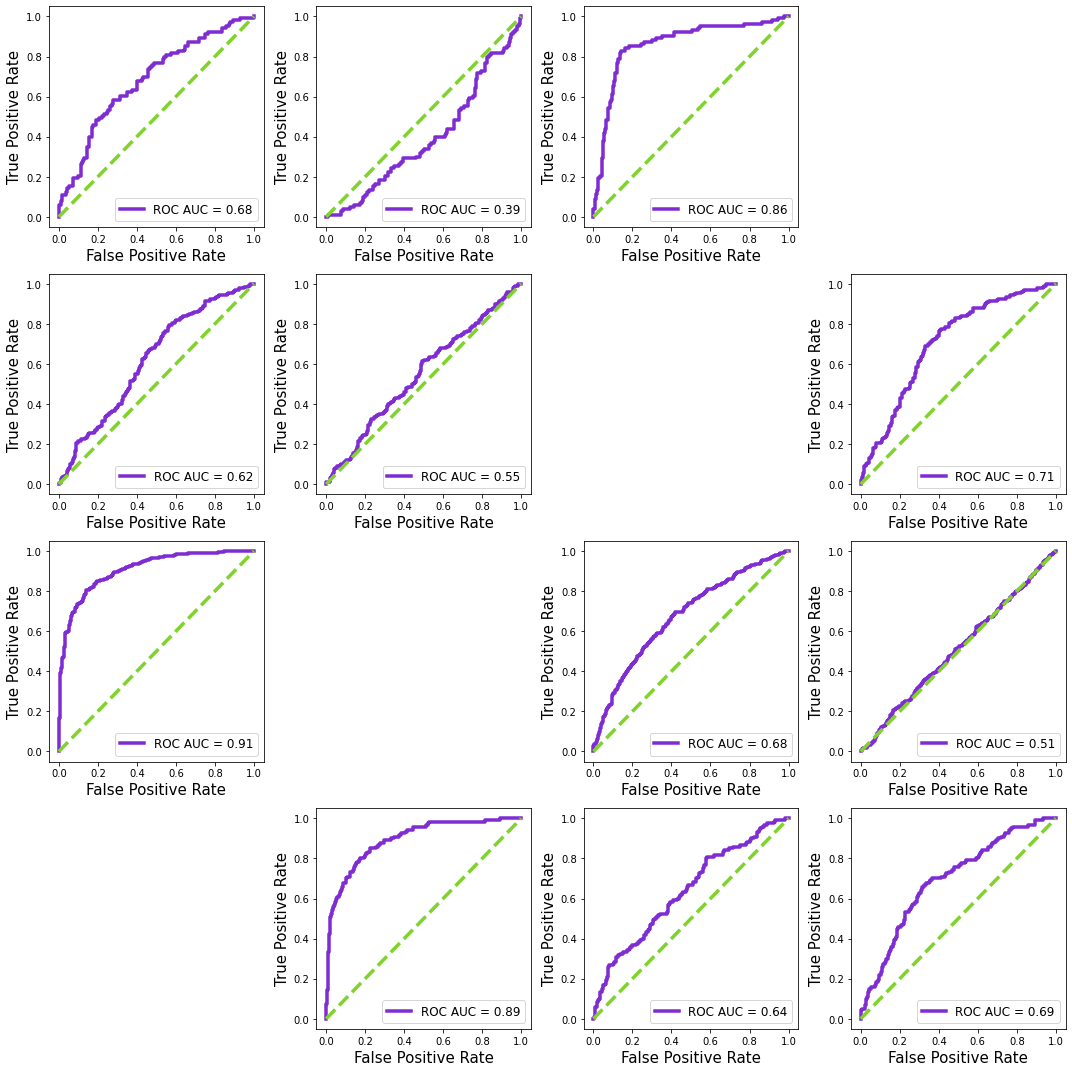

In [12]:
plt.rcParams["figure.figsize"] = (15, 15)
run_RFclassifier_rocauc()

### Plot waterfall (see waterfall_plot.R)

#### RF waterfall 

In [15]:
#------MAKE HIST RF------

parameters = {'criterion': ['gini'], 'max_depth' : [3, 5, 7], 'min_samples_leaf': [4, 10, 20],
               'min_samples_split': [10, 20, 40], 'max_features': [15, 20, 50]}
column_names=[*["normalization", "features", "mismatch", "weight"], *model_permutation]
datasets=list(permutations((fmba_set1, fmba_set2, adaptive_set1, adaptive_set2), 2))

def run_RFclassifier_hist(datasets=datasets, parameters=parameters):   
    counter=0
    for dataset in datasets:
        train_set, test_set=iter(dataset)
#------split into features matrix X and vector with ansvers y-----
        X_to_fit=train_set[train_set.columns[~train_set.columns.isin(["status"])]]
        y_to_fit=train_set["status"]
        X_test=test_set[test_set.columns[~test_set.columns.isin(["status"])]]
        y_test=test_set["status"]
#-----find hyperparameters----
        clf=RandomizedSearchCV(RandomForestClassifier(class_weight="balanced"), parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        clf.fit(X_to_fit, y_to_fit)
        #-----best estimator-----
        RF=clf.best_estimator_
        best_parameter=clf.best_params_
        y_pred=RF.predict(X_test)
        y_predicted_prob = RF.predict_proba(X_test)
#-----make hist-----        
        labels=y_test
        hist=pd.DataFrame(y_predicted_prob)
        hist.index=X_test.index
        hist["label"]=labels
        hist["healthy_prob"]=hist[1]-0.5
        hist=hist.sort_values(by=['healthy_prob'])
        hist["index"]=range(len(list(y_test)))
        file_name="_".join(model_permutation[counter].split(sep="/"))
        hist.to_csv(f"plots/hist/data_RF_3/{file_name}.tsv",sep="\t")
        counter+=1
 #       colors=["#F85C70" if x == "COVID" else "#41729F" for xT in hist["healthy_prob"]]
 #       plt.figure()
 #       plt.hist(hist["healthy_prob"], len(), histtype='bar')
 #       plt.title(f"{model_permutation[counter]}");
run_RFclassifier_hist()        

/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.8s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.0s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.9s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.0s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.3s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.7s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.7s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.2s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.7s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.7s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    8.5s finished
/home/daria/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    9.7s finished
